In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# path_to_zip_file = './drive/MyDrive/rpdata.zip'
# directory_to_extract_to = './drive/MyDrive/'
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [2]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
     |████████████████████████████████| 376 kB 31.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=cac07aaa2b63229bc7960912ae9495404ab6ea60156d43f0b55b2bed8f0a0832
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=cbda6771386a8c1def9e64fd5ffae5951aa26f10dd4a96f18233872aa6a59de5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from PIL import Image
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm
import random
import pickle
import torchvision.transforms
from sklearn.model_selection import train_test_split as tts
from torch.optim.lr_scheduler import _LRScheduler
from scipy.spatial.distance import directed_hausdorff
import copy
import math
import os
import segmentation_models_pytorch as smp
from scipy.ndimage.morphology import distance_transform_edt as edt
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

In [4]:
model = smp.DeepLabV3Plus(encoder_name='efficientnet-b1',encoder_weights='imagenet', classes=3,in_channels=3)
device = 'cuda'
model.cuda()
print('')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

In [5]:
"""
Hausdorff loss implementation based on paper:
https://arxiv.org/pdf/1904.10030.pdf
"""

class HausdorffDTLoss(nn.Module):
    """Binary Hausdorff loss based on distance transform"""

    def __init__(self, device,alpha=2.0,  **kwargs):
        super(HausdorffDTLoss, self).__init__()
        self.alpha = alpha
        self.device = device

    @torch.no_grad()
    def distance_field(self, img: np.ndarray) -> np.ndarray:
        field = np.zeros_like(img)

        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5

            if fg_mask.any():
                bg_mask = ~fg_mask

                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)

                field[batch] = fg_dist + bg_dist

        return field

    def forward(
        self, pred: torch.Tensor, target: torch.Tensor, debug=False
    ) -> torch.Tensor:
        """
        Uses one binary channel: 1 - fg, 0 - bg
        pred: (b, 1, x, y, z) or (b, 1, x, y)
        target: (b, 1, x, y, z) or (b, 1, x, y)
        """
        assert pred.dim() == 4 or pred.dim() == 5, "Only 2D and 3D supported"
        assert (
            pred.dim() == target.dim()
        ), "Prediction and target need to be of same dimension"

        pred = torch.sigmoid(pred)

        pred_dt = torch.from_numpy(self.distance_field(pred.detach().cpu().numpy())).float()
        target_dt = torch.from_numpy(self.distance_field(target.detach().cpu().numpy())).float()

        pred_error = (pred - target) ** 2
        distance = pred_dt ** self.alpha + target_dt ** self.alpha

        dt_field = pred_error * distance.to(self.device)
        loss = dt_field.mean()

        if debug:
            return (
                loss.cpu().numpy(),
                (
                    dt_field.cpu().numpy()[0, 0],
                    pred_error.cpu().numpy()[0, 0],
                    distance.cpu().numpy()[0, 0],
                    pred_dt.cpu().numpy()[0, 0],
                    target_dt.cpu().numpy()[0, 0],
                ),
            )

        else:
            return loss


class HausdorffERLoss(nn.Module):
    """Binary Hausdorff loss based on morphological erosion"""

    def __init__(self, alpha=2.0, erosions=10, **kwargs):
        super(HausdorffERLoss, self).__init__()
        self.alpha = alpha
        self.erosions = erosions
        self.prepare_kernels()

    def prepare_kernels(self):
        cross = np.array([cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))])
        bound = np.array([[[0, 0, 0], [0, 1, 0], [0, 0, 0]]])

        self.kernel2D = cross * 0.2
        self.kernel3D = np.array([bound, cross, bound]) * (1 / 7)

    @torch.no_grad()
    def perform_erosion(
        self, pred: np.ndarray, target: np.ndarray, debug
    ) -> np.ndarray:
        bound = (pred - target) ** 2

        if bound.ndim == 5:
            kernel = self.kernel3D
        elif bound.ndim == 4:
            kernel = self.kernel2D
        else:
            raise ValueError(f"Dimension {bound.ndim} is nor supported.")

        eroted = np.zeros_like(bound)
        erosions = []

        for batch in range(len(bound)):

            # debug
            erosions.append(np.copy(bound[batch][0]))

            for k in range(self.erosions):

                # compute convolution with kernel
                dilation = convolve(bound[batch], kernel, mode="constant", cval=0.0)

                # apply soft thresholding at 0.5 and normalize
                erosion = dilation - 0.5
                erosion[erosion < 0] = 0

                if erosion.ptp() != 0:
                    erosion = (erosion - erosion.min()) / erosion.ptp()

                # save erosion and add to loss
                bound[batch] = erosion
                eroted[batch] += erosion * (k + 1) ** self.alpha

                if debug:
                    erosions.append(np.copy(erosion[0]))

        # image visualization in debug mode
        if debug:
            return eroted, erosions
        else:
            return eroted

    def forward(
        self, pred: torch.Tensor, target: torch.Tensor, debug=False
    ) -> torch.Tensor:
        """
        Uses one binary channel: 1 - fg, 0 - bg
        pred: (b, 1, x, y, z) or (b, 1, x, y)
        target: (b, 1, x, y, z) or (b, 1, x, y)
        """
        assert pred.dim() == 4 or pred.dim() == 5, "Only 2D and 3D supported"
        assert (
            pred.dim() == target.dim()
        ), "Prediction and target need to be of same dimension"

        # pred = torch.sigmoid(pred)

        if debug:
            eroted, erosions = self.perform_erosion(
                pred.cpu().numpy(), target.cpu().numpy(), debug
            )
            return eroted.mean(), erosions

        else:
            eroted = torch.from_numpy(
                self.perform_erosion(pred.cpu().numpy(), target.cpu().numpy(), debug)
            ).float()

            loss = eroted.mean()

            return loss

In [6]:
class customdataset(Dataset):
    def __init__(self, img_dir, target_dir, imglist):
        self.img_dir = img_dir
        self.target_dir = target_dir
        self.imglist = imglist

    def __len__(self):
        return len(self.imglist)

    def __getitem__(self, idx):
        img_path = self.img_dir + self.imglist[idx]
        image = np.load(img_path)/255
        image = torch.tensor(image[np.newaxis].repeat(3,0)).float()

        label_path = self.target_dir + self.imglist[idx][:-4] + '.pkl'
        with open(label_path,'rb') as f:
            labels = pickle.load(f)
        label = []
        for i in labels:
            if len(i)==0:
                label.append(np.zeros((1,224,224)))
            else:
                temp = np.zeros(224*224)
                temp[np.array(i)]=1
                label.append(temp.reshape(1,224,224))
        return image, torch.tensor(np.vstack(label)).float()

In [7]:
epochs = 1000
batch_size = 16
learning_rate = 0.001
weight_decay = 0.001
model_name = 'deeplabv3plus_effice_b1_hd2.pth'
log_interval = 100
lam_tvs = .5
lam_bce = .5
lam_lloss = .5
lam_hd = .0001

In [8]:
def dice_loss(pred, target, smooth = 1e-5):
    prob_pred = torch.sigmoid(pred)
    intersection = (prob_pred * target).sum(dim=(2,3))
    union = prob_pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    
    # dice coefficient
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    # dice loss
    dice_loss = 1.0 - dice
    
    # total loss
    loss = dice_loss
    
    return loss.sum(), dice.sum()

In [9]:
def test_dice_measure(pred, target, smooth = 1e-5):
    prob_pred = torch.sigmoid(pred)
    prob_pred = (prob_pred > .5) + 0
    intersection = (prob_pred * target).sum(dim=(2,3))
    union = prob_pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    
    # dice coefficient
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return dice.sum()

In [10]:
def dicescore(im1, im2, empty_score=1.0):

    im1 = np.asarray(im1)==1
    im2 = np.asarray(im2)==1

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [11]:
def hd_dist(preds, targets):
    preds_coords = np.argwhere(preds) / np.array(preds.shape)[np.newaxis,:]
    targets_coords = np.argwhere(targets) / np.array(preds.shape)[np.newaxis,:]
    haussdorf_dist = directed_hausdorff(preds_coords, targets_coords)[0]
    return haussdorf_dist

In [12]:
def test_dice_measure2(pred, target, smooth = 1e-5):
    prob_pred = torch.sigmoid(pred)
    prob_pred = (prob_pred > .5) + 0
    
    prob_pred1 = prob_pred[:,0,:,:]
    prob_pred2 = prob_pred[:,1,:,:]
    prob_pred3 = prob_pred[:,2,:,:]
    
    target1 = target[:,0,:,:]
    target2 = target[:,1,:,:]
    target3 = target[:,2,:,:]
    
    dice1 = []
    dice2 = []
    dice3 = []
    for i in range(pred.shape[0]):
        if target1[i].sum()!=0:
            intersection = (prob_pred1[i] * target1[i]).sum(dim=(0,1))
            union = prob_pred1[i].sum(dim=(0,1)) + target1[i].sum(dim=(0,1))
            dice1.append((2.0 * intersection + smooth) / (union + smooth))
        if target2[i].sum()!=0:
            intersection = (prob_pred2[i] * target2[i]).sum(dim=(0,1))
            union = prob_pred2[i].sum(dim=(0,1)) + target2[i].sum(dim=(0,1))
            dice2.append((2.0 * intersection + smooth) / (union + smooth))           
        if target3[i].sum()!=0:
            intersection = (prob_pred3[i] * target3[i]).sum(dim=(0,1))
            union = prob_pred3[i].sum(dim=(0,1)) + target3[i].sum(dim=(0,1))
            dice3.append((2.0 * intersection + smooth) / (union + smooth)) 
        
    if len(dice1)==0:
        dice1 = torch.tensor([0]).float()
    else:
        dice1 = torch.stack(dice1).mean()
    if len(dice2)==0:
        dice2 = torch.tensor([0]).float()
    else:
        dice2 = torch.stack(dice2).mean()
    if len(dice3)==0:
        dice3 = torch.tensor([0]).float()
    else:
        dice3 = torch.stack(dice3).mean()
        
    return dice1, dice2, dice3

In [13]:
class WarmupConstantSchedule(torch.optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, warmup_steps, last_epoch=-1):
        def lr_lambda(step):
            if step < warmup_steps:
                return float(step) / float(max(1.0, warmup_steps))
            return 1.
        super(WarmupConstantSchedule, self).__init__(optimizer, lr_lambda, last_epoch=last_epoch)

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [14]:
loss_fn_dice = smp.losses.DiceLoss(mode='binary')
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_fn_Lovasz = smp.losses.LovaszLoss(mode='binary')
loss_fn_tversky = smp.losses.TverskyLoss(mode='binary',alpha=.7,beta=.3,gamma=3)
loss_hd = HausdorffDTLoss(device)

# optimizer = optim.AdamW(model.parameters(),lr = 0.000001, weight_decay = weight_decay)
optimizer = optim.RAdam(model.parameters(),lr = 0.000001, weight_decay = weight_decay)
# optimizer = optim.Adam(model.parameters(),lr = 0.001, weight_decay = weight_decay)
# scheduler = WarmupConstantSchedule(optimizer, warmup_steps=10)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=150, T_mult=1, eta_max=learning_rate,  T_up=10, gamma=0.5) 

In [17]:
img_dir = '/content/drive/MyDrive/img/'
target_dir = '/content/drive/MyDrive/label/'

imglist = os.listdir(img_dir)
caselist = [i.split('_')[0] for i in imglist]
traincase,testcase = tts(np.unique(caselist).tolist(),test_size=.2, random_state=123)
trainimglist = [i for i in imglist if i.split('_')[0] in traincase]
testimglist = [i for i in imglist if i.split('_')[0] in testcase]
# trainimglist, testimglist = tts(os.listdir(img_dir),test_size=.2, random_state=123)

In [18]:
traindata = customdataset(img_dir,target_dir,trainimglist)
testdata = customdataset(img_dir,target_dir,testimglist)
traindataloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, num_workers=0, shuffle=True)
testdataloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, num_workers=0, shuffle=False)

In [25]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize([.5,.5,.5],[.5,.5,.5]),
])

jittering = torchvision.transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3)

def img_target_transform(a,b):
    a = jittering(a)
    a = img_transform(a)
#     if random.uniform(0,1) > .7:
#         a += .3*torch.randn(a.size())
    if random.uniform(0,1) > .7:
        a = torchvision.transforms.functional.hflip(a)
        b = torchvision.transforms.functional.hflip(b)
    if random.uniform(0,1) > .7:
        a = torchvision.transforms.functional.vflip(a)
        b = torchvision.transforms.functional.vflip(b)
    if random.uniform(0,1) > .7:
        angle=random.uniform(-1,1) * 20
        a = torchvision.transforms.functional.rotate(a,angle)
        b = torchvision.transforms.functional.rotate(b,angle)
    return a,b

In [ ]:
moglobaltestloss = []
globaltrainloss = []
globaldice = []
globalfinalscore = []

In [ ]:
for epoch in range(epochs):
    
    #train data
    trainloss = []
    traintverskyloss = []
    trainbceloss = []
    trainlovaszloss = []
    trainhdloss = []

    model.train()
    for bi, (x,target) in enumerate(tqdm(traindataloader)):
        optimizer.zero_grad()
        x,target = img_target_transform(x,target)

        pred = model(x.to(device))
        # bpred = (torch.sigmoid(pred) > .5)+0

        bce_loss = loss_fn_bce(pred,target.to(device))
        lloss = loss_fn_Lovasz(pred,target.to(device))
        tloss = loss_fn_tversky(pred,target.to(device))
        hdloss = 0
        for i in range(3):
            hdloss += loss_hd(pred[:,i,:,:][:,np.newaxis,:,:],target[:,i,:,:][:,np.newaxis,:,:].to(device))
        hdloss /= 3

        loss = lam_tvs * tloss + lam_bce * bce_loss + lam_lloss * lloss + lam_hd * hdloss

        loss.backward()
        optimizer.step()

        trainloss.append(loss.item())
        trainlovaszloss.append(lloss.item())
        traintverskyloss.append(tloss.item())
        trainbceloss.append(bce_loss.item())
        trainhdloss.append(hdloss.item())

        if ((bi) % 300)==0:
            print('Train Total Loss:',np.mean(trainloss), 'Train tversky Loss:',np.mean(traintverskyloss),\
                'Train BCE Loss:',np.mean(trainbceloss),'Train Lovasz: ',np.mean(trainlovaszloss),'Train HD: ',np.mean(trainhdloss)) #

    globaltrainloss.append(np.mean(trainloss))

    #test data
    model.eval()
    with torch.no_grad():
        testloss = []
        testtverskyloss = []
        testbceloss = []
        testlovaszloss = []
        testhdloss = []

        finalscores = []
        dices1 = []
        dices2 = []
        dices3 = []
        hds1 = []
        hds2 = []
        hds3 = []
        dicemeasures = []

        for bi, (x,target) in enumerate(tqdm(testdataloader)):
            x = img_transform(x)
            pred = model(x.to(device))
            bpred = (torch.sigmoid(pred) > .5)+0

            dice1 = []
            dice2 = []
            dice3 = []

            for i in range(0, bpred.shape[0]):
                dice1.append(dicescore(bpred[i, 0, :, :].detach().cpu().numpy(), target[i, 0, :, :].detach().numpy()))
                dice2.append(dicescore(bpred[i, 1, :, :].detach().cpu().numpy(), target[i, 1, :, :].detach().numpy()))
                dice3.append(dicescore(bpred[i, 2, :, :].detach().cpu().numpy(), target[i, 2, :, :].detach().numpy()))

    
            dicescore1 = np.mean(dice1)
            dicescore2 = np.mean(dice2)
            dicescore3 = np.mean(dice3)


            hd1 = 1 - hd_dist(bpred[:,0,:,:].detach().cpu().numpy(),target[:,0,:,:].detach().numpy())
            hd2 = 1 - hd_dist(bpred[:,1,:,:].detach().cpu().numpy(),target[:,1,:,:].detach().numpy())
            hd3 = 1 - hd_dist(bpred[:,2,:,:].detach().cpu().numpy(),target[:,2,:,:].detach().numpy())


            bce_loss = loss_fn_bce(pred,target.to(device))
            lloss = loss_fn_Lovasz(pred,target.to(device))
            tloss = loss_fn_tversky(pred,target.to(device))
            hdloss = 0
            for i in range(3):
                hdloss += loss_hd(pred[:,i,:,:][:,np.newaxis,:,:],target[:,i,:,:][:,np.newaxis,:,:].to(device))
            hdloss /= 3

            loss = lam_tvs * tloss + lam_bce * bce_loss + lam_lloss * lloss + lam_hd * hdloss

            dicemeasure = (dicescore1 + dicescore2 + dicescore3)/3
            hdscore = (hd1+hd2+hd3)/3
            finalscore = (.4*dicemeasure) + (.6*hdscore)
            
            testloss.append(loss.item())
            testtverskyloss.append(tloss.item())
            testlovaszloss.append(lloss.item())
            testbceloss.append(bce_loss.item())
            testhdloss.append(hdloss.item())
            dices1.append(dicescore1)
            dices2.append(dicescore2)
            dices3.append(dicescore3)
            hds1.append(hd1)
            hds2.append(hd2)
            hds3.append(hd3)
            finalscores.append(finalscore)
            dicemeasures.append(dicemeasure)

        print('Epoch:',epoch+1,'Test Total Loss:',np.mean(testloss), 'Test Tversky Loss:',np.mean(testtverskyloss),\
            'Test BCE Loss:',np.mean(testbceloss),'Test lovasz',np.mean(testlovaszloss),'Test HD: ',np.mean(testhdloss)) #
        print('Dice1 :',np.mean(dices1),'Dice2 :',np.mean(dices2),'Dice3 :',np.mean(dices3))
        print('HD1 :',np.mean(hds1),'HD2 :',np.mean(hds2),'HD3 :',np.mean(hds3))
        print('Final Score :',np.mean(finalscores))

        if len(globalfinalscore) == 0:
          torch.save(model.state_dict(),'/content/drive/MyDrive/models/' + model_name)
        elif max(globalfinalscore) < np.mean(finalscores):
          torch.save(model.state_dict(),'/content/drive/MyDrive/models/' + model_name)
        globalfinalscore.append(np.mean(finalscores))
        globaldice.append(np.mean(dicemeasures))
    scheduler.step()

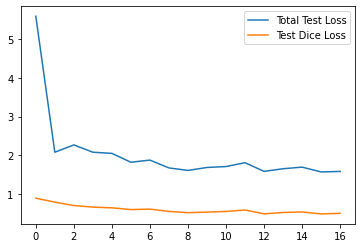

In [ ]:
import matplotlib.pyplot as plt
plt.plot(globaltestloss,label='Total Test Loss')
plt.plot(globaldiceloss, label='Test Dice Loss')
plt.legend()

### Checking result

In [19]:
model_name = 'deeplabv3plus_effice_b1_hd.pth'
model.load_state_dict(torch.load('/content/drive/MyDrive/models/' + model_name))
model.eval()
print('')

In [20]:
def label_to_arr(label_path):
  with open(label_path,'rb') as f:
      labels = pickle.load(f)
  label = []
  for i in labels:
      if len(i)==0:
          label.append(np.zeros((1,224,224)))
      else:
          temp = np.zeros(224*224)
          temp[np.array(i)]=255
          label.append(temp.reshape(1,224,224))
  return np.vstack(label)

####  Ground Truth

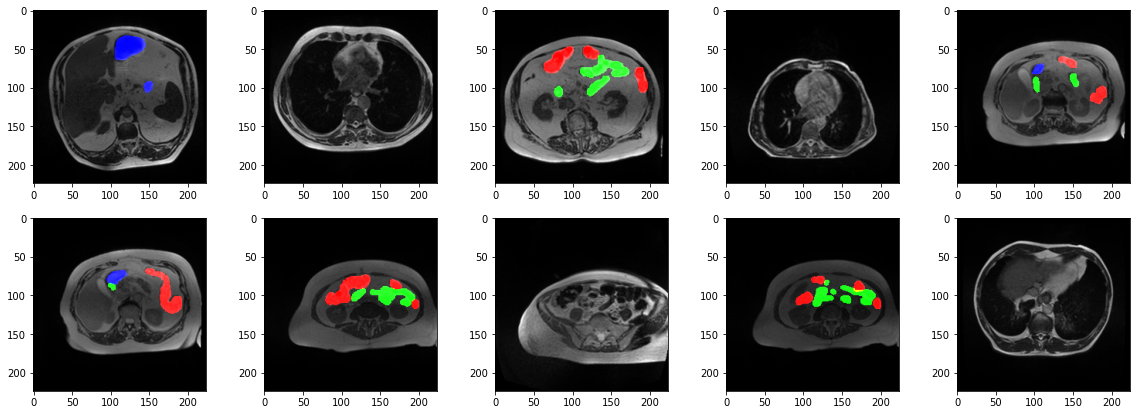

In [23]:
plt.figure(figsize=(20,7))
samplepics = []
for i in range(10):
  samplepic = random.choice(testimglist)
  img = np.load(img_dir + samplepic)
  target = label_to_arr(target_dir + samplepic[:-4] + '.pkl')
  img = img[:,:,np.newaxis].repeat(3,2)
  img[np.moveaxis(target,0,-1)==255]=255
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  samplepics.append(samplepic)

#### Predictions

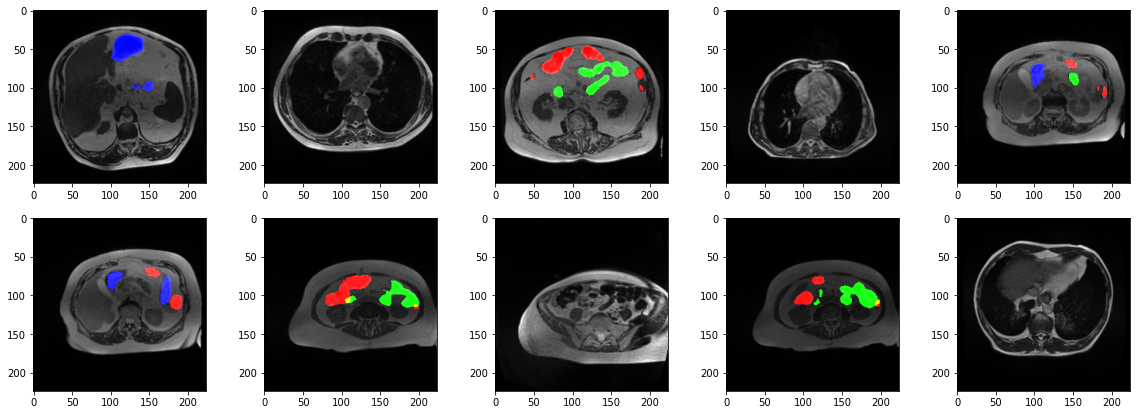

In [30]:
model.eval()
j=1
plt.figure(figsize=(20,7))
for i in samplepics:
  img = np.load(img_dir + i)
  img = img[:,:,np.newaxis].repeat(3,2)
  with torch.no_grad():
      pred = model(img_transform(torch.tensor(np.moveaxis(img,-1,0)[np.newaxis]).float()/255).cuda())
      predmap = ((torch.sigmoid(pred)[0].permute(1,2,0).detach().cpu().numpy() > .5)+0)*255
  img[predmap==255]=255
  plt.subplot(2,5,j)
  plt.imshow(img)
  j+=1